Suppose that we are working with some doctors on heart attack patients. The dependent variable is whether the patient has had a second heart attack ($Y$)within 1 year (yes = 1). We have two independent variables, one is whether the patient completed a treatment consistent of anger control practices ($x_1$) (yes=1). The other is a score on a trait anxiety scale ($x_2$) (a higher score means more anxious). You want to model

$Y\sim {\rm Ber}(p_i)$

where $p_i=\sigma(x_iW+b)$ with $W=
\left(\begin{matrix}
W_1\\
W_2
\end{matrix}\right).
$

Answer the following problems:

1. Transform `Y` into `T` with one-hot encoding.

2. Build the model which best describe the heart attack mechanism. You may want to standardize the explanatory variables before define the model.

3. In the model, make the probability function `Q`, then train the logistic model.

4. Calculate the train accuracy of the model.

<img src="https://drive.google.com/uc?id=1BJMmWmeDUJFXis6nc7X7Sd6o832B1_OC" height="600" width="400">

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
data = np.array([[1,1,70], [1,1,80], [1,1,50],[1,0,60], [1,0,40], [1, 0, 65], [1,0,75], [1,0,80], [1,0,70], [1,0,60], [0,1,65], [0,1,50], [0,1,45], [0,1,35], [0,1,40], [0,1,50], [0,0,55], [0,0,45], [0,0,50], [0,0,60]], dtype=np.float32)
data

array([[ 1.,  1., 70.],
       [ 1.,  1., 80.],
       [ 1.,  1., 50.],
       [ 1.,  0., 60.],
       [ 1.,  0., 40.],
       [ 1.,  0., 65.],
       [ 1.,  0., 75.],
       [ 1.,  0., 80.],
       [ 1.,  0., 70.],
       [ 1.,  0., 60.],
       [ 0.,  1., 65.],
       [ 0.,  1., 50.],
       [ 0.,  1., 45.],
       [ 0.,  1., 35.],
       [ 0.,  1., 40.],
       [ 0.,  1., 50.],
       [ 0.,  0., 55.],
       [ 0.,  0., 45.],
       [ 0.,  0., 50.],
       [ 0.,  0., 60.]], dtype=float32)

In [25]:
# Y one hot encoding
Y = torch.tensor(data[:, 0], dtype=torch.int64)
T = torch.nn.functional.one_hot(Y, num_classes=2)
T = T.to(torch.float32)
T

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [27]:
# X standardize
X = torch.tensor(data[:, 1:], dtype=torch.float32)
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
XX = (X-X_mean) / X_std

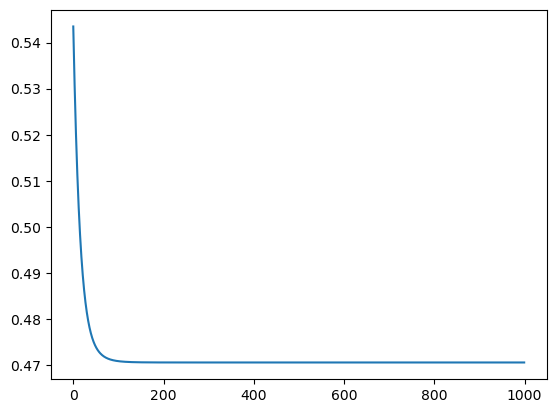

In [29]:
model = torch.nn.Linear(2,2,bias=True) # W: [2,2], Y=X@W
def forward(xx):  # z = forward(xx)
  return torch.exp(model(xx))

def loss_ftn(T, qhat):
  temp = - torch.mean(torch.sum(T * torch.log(qhat), axis=1))
  return temp

optimizer = torch.optim.SGD(model.parameters(), lr= 0.1)

history=[]
epochs = 1000

for i in range(epochs):
  zhat = forward(XX) #[n,1] y=1의 확률
  qhat = zhat/torch.sum(zhat, axis=1).reshape([-1,1])
  loss = loss_ftn(T, qhat)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  history.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(history)

In [30]:
# accuracy
Zhat = forward(XX)
Qhat = Zhat/torch.sum(Zhat, axis=1).reshape([-1,1])
Qhat

Yhat = torch.argmax(Qhat, axis=1)
Y = torch.argmax(T, axis=1)

torch.mean((Yhat == Y)*1.0) 

tensor(0.7500)

* batch learning

In [35]:
dataset = TensorDataset(T,XX)
trainloader = DataLoader(dataset=dataset, batch_size=20, shuffle=True)

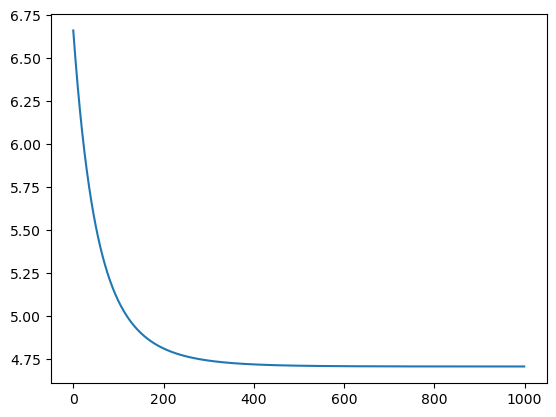

In [39]:
model = torch.nn.Sequential(
    torch.nn.Linear(2,1, bias=True),
    torch.nn.Sigmoid()
)


def loss_ftn(tt, qhat):
  temp = -torch.mean(tt*torch.log(qhat))
  return temp

optimizer = torch.optim.SGD(model.parameters(), lr= 0.1)

history=[]
epochs = 1000
n=len(XX)

for i in range(epochs):
  epoch_loss = 0.0
  for tt, xx in trainloader:
    phat = model(xx) #[n,1] y=1의 확률
    qhat = torch.concat([1-phat, phat], axis=1)
    loss = loss_ftn(tt, qhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss = epoch_loss + loss.item()*len(tt)
  history.append(epoch_loss)

plt.plot(history)

In [41]:
def accuracy_ftn(phat, t):
  yhat = (phat>0.5).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1,1])==yhat).to(torch.float32))
  return accuracy

phat = model(XX)
accuracy = accuracy_ftn(phat, T)
accuracy

tensor(0.7500)

In [ ]:
z_model = nn.Linear(784, 10, bias=True)

def loss_fn(qhat, t):
  loss = - torch.mean(torch.sum(t * torch.log(qhat), axis=1))
  return loss

optimizer = torch.optim.SGD(z_model.parameters(), lr=0.01)
history=[]
epochs = 30

for epoch in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    zhat = z_model(xx)
    qhat = torch.softmax(zhat, dim=1)
    loss = loss_fn(qhat, tt)
    loss.backward()
    epoch_loss += loss.item()*len(xx)
    optimizer.step()
    optimizer.zero_grad()
  history.append(epoch_loss/n)
plt.plot(history)

In [ ]:
z_model = nn.Linear(784, 10, bias=True) #X:[n, 784] #name changed

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')# This is the only change

optimizer = torch.optim.SGD(z_model.parameters(), lr=0.01)
history=[]
epochs = 10

for epoch in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    zhat = z_model(xx)
    loss = loss_fn(zhat, tt)
    loss.backward()
    epoch_loss += loss.item()*len(xx)
    optimizer.step()
    optimizer.zero_grad()
  history.append(epoch_loss/n)
plt.plot(history)

In [ ]:
def accuracy_ftn(phat, t):
  yhat = torch.argmax(phat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1])==yhat).to(torch.float32))
  return accuracy

phat = torch.softmax(z_model(x_test), axis=1)
accuracy = accuracy_ftn(phat, t_test)
accuracy